## Create AI Web Assistants: Playwright, LangChain & Gradio Implementation

This is the start of an AWESOME project! Really simple and very effective.

### First - a heads up for Windows PC users

While executing this notebook, you might hit a problem with the Playwright browser raising a NotImplementedError.

This should work when we move to python modules, but it can cause problems in Windows in a notebook.

If you it this error and would like to run the notebook, you need to make a small change which seems quite hacky!

1. Right click in `.venv` in the File Explorer on the left and select "Find in folder"
2. Search for `asyncio.set_event_loop_policy(WindowsSelectorEventLoopPolicy())`  
3. That code should be found in a line of code in a file called `kernelapp.py`
4. Comment out that line of code in that file! And save the file. (And in fact, student William Lapa tells me that he needed to comment out the entire else statement that this line is part of.)
5. Restart the kernel by pressing the "Restart" button above

Thank you to student Nicolas for finding this, and to Yaki, Zibin and Bhaskar for confirming that this worked for them!

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.prebuilt import ToolNode, tools_condition
import requests
import os
from langchain.agents import Tool

from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

In [2]:
load_dotenv(override=True)

True

### Asynchronous LangGraph

To run a tool:  
Sync: `tool.run(inputs)`  
Async: `await tool.arun(inputs)`

To invoke the graph:  
Sync: `graph.invoke(state)`  
Async: `await graph.ainvoke(state)`

In [3]:
class State(TypedDict):
    
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [4]:
pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

tool_push = Tool(
        name="send_push_notification",
        func=push,
        description="useful for when you want to send a push notification"
    )

### Next: Install Playwright

On Windows and MacOS:  
`playwright install`

On Linux:  
`playwright install —with-reps chromium`

### Introducing nest_asyncio

Python async code only allows for one "event loop" processing aynchronous events.

The `nest_asyncio` library patches this, and is used for special situations, if you need to run a nested event loop.



In [8]:
import nest_asyncio
nest_asyncio.apply()

### The LangChain community

One of the remarkable things about LangChain is the rich community around it.

Check this out:


In [9]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

async_browser =  create_async_playwright_browser(headless=False)  # headful mode
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

In [10]:
for tool in tools:
    print(f"{tool.name}={tool}")

click_element=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/krishna/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
navigate_browser=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/krishna/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
previous_webpage=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/krishna/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
extract_text=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/krishna/Library/Caches/ms-playwright/chromium-1169/chrome-mac/Chromium.app/Contents/MacOS/Chromium> version=136.0.7103.25>
extract_hyperlinks=async_browser=<Browser type=<BrowserType name=chromium executable_path=/Users/krishna/Library/Caches/ms-playwright/c

In [11]:
tool_dict = {tool.name:tool for tool in tools}

navigate_tool = tool_dict.get("navigate_browser")
extract_text_tool = tool_dict.get("extract_text")

    
await navigate_tool.arun({"url": "https://www.cnn.com"})
text = await extract_text_tool.arun({})

In [12]:
import textwrap
print(textwrap.fill(text))

Breaking News, Latest News and Videos | CNN CNN values your feedback
1. How relevant is this ad to you? 2. Did you encounter any technical
issues? No Video player was slow to load content Video content never
loaded Ad froze or did not finish loading Video content did not start
after ad Audio on ad was too loud Other issues Ad never loaded Ad
prevented/slowed the page from loading Content moved around while ad
loaded Ad was repetitive to ads I've seen previously Other issues
Cancel Submit Thank You! Your effort and contribution in providing
this feedback is much
appreciated. Close Ad Feedback Close icon US World Politics Business
Health Entertainment Style Travel Sports Science Climate Weather
Ukraine-Russia War Israel-Hamas War Underscored Games More US World
Politics Business Health Entertainment Style Travel Sports Science
Climate Weather Ukraine-Russia War Israel-Hamas War Underscored Games
Watch Listen Live TV Subscribe Sign in My Account Settings Newsletters
Topics you follow Sign

In [13]:
all_tools = tools + [tool_push]

In [14]:

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(all_tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


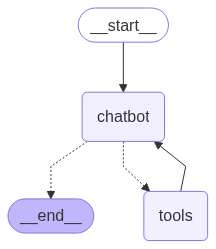

In [15]:

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=all_tools))
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
config = {"configurable": {"thread_id": "10"}}

async def chat(user_input: str, history):
    result = await graph.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.
